In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch

torch.__version__

'1.12.0+cu113'

In [2]:
!pip install mmcv-full==1.6.0 -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git
!cd mmsegmentation; python setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.1 MB 10.7 MB/s 
     |████████████████████████████████| 190 kB 5.2 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 10253, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 10253 (delta 38), reused 90 (delta 23), pack-reused 10125
Receiving objects: 100% (10253/10253), 14.07 MiB | 32.44 MiB/s, done.
Resolving deltas: 100% (7481/7481), done.
running install
running bdist_egg
running egg_info
creating mmsegmentation.egg-info
writing mmsegmentation.egg-info/PKG-INFO
writing dependency_links to mmsegmentation.egg-info/dependency_links.txt
writing requirements to mmsegmentation.egg-info/requires.txt
writing top-level names to mmsegmentation.egg-info/top_level.txt
writing manifes

In [3]:
%cd mmsegmentation

from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

%cd /content

/content/mmsegmentation
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/content


In [4]:
!mkdir /content/mmsegmentation/checkpoints
!wget -O /content/mmsegmentation/checkpoints/deeplabv3plus_r101-d8_512x1024_80k_cityscapes_20200606_114143-068fcfe9.pth https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r101-d8_512x1024_80k_cityscapes/deeplabv3plus_r101-d8_512x1024_80k_cityscapes_20200606_114143-068fcfe9.pth

config_file = '/content/mmsegmentation/configs/deeplabv3plus/deeplabv3plus_r101-d8_512x1024_80k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/deeplabv3plus_r101-d8_512x1024_80k_cityscapes_20200606_114143-068fcfe9.pth'

--2022-08-02 10:38:53--  https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r101-d8_512x1024_80k_cityscapes/deeplabv3plus_r101-d8_512x1024_80k_cityscapes_20200606_114143-068fcfe9.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.89.140.71
Connecting to download.openmmlab.com (download.openmmlab.com)|47.89.140.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250971113 (239M) [application/octet-stream]
Saving to: ‘/content/mmsegmentation/checkpoints/deeplabv3plus_r101-d8_512x1024_80k_cityscapes_20200606_114143-068fcfe9.pth’

/content/mmsegmenta 100%[===================>] 239.34M  8.71MB/s    in 29s     

2022-08-02 10:39:22 (8.40 MB/s) - ‘/content/mmsegmentation/checkpoints/deeplabv3plus_r101-d8_512x1024_80k_cityscapes_20200606_114143-068fcfe9.pth’ saved [250971113/250971113]



In [5]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import os.path as osp

classes = ('background', 'scratch')
palette = [[255, 255, 255], [255, 0, 0]]

@DATASETS.register_module(force=True)
class ScratchDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.tif', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [6]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
      

In [7]:
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(700, 700), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(700, 700), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    # dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    # dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(700, 700),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [9]:
from mmseg.apis import set_random_seed

cfg.dataset_type = 'ScratchDataset'
cfg.data_root = '/content/drive/MyDrive/Colab Notebooks/ScratchDataset'

cfg.data.train.type = 'ScratchDataset'
cfg.data.train.data_root = '/content/drive/MyDrive/Colab Notebooks/ScratchDataset'
cfg.data.train.img_dir = 'img_dir/train'
cfg.data.train.ann_dir = 'ann_dir/train'
cfg.data.train.split = 'train.txt'
cfg.data.train.pipeline = cfg.train_pipeline

cfg.data.val.type = 'ScratchDataset'
cfg.data.val.data_root = '/content/drive/MyDrive/Colab Notebooks/ScratchDataset'
cfg.data.val.img_dir = 'img_dir/val'
cfg.data.val.ann_dir = 'ann_dir/val'
cfg.data.val.split = 'val.txt'
cfg.data.val.pipeline = cfg.test_pipeline

cfg.data.test.type = 'ScratchDataset'
cfg.data.test.data_root = '/content/drive/MyDrive/Colab Notebooks/ScratchDataset'
cfg.data.test.img_dir = 'img_dir/val'
cfg.data.test.ann_dir = 'ann_dir/val'
cfg.data.test.split = 'val.txt'
cfg.data.test.pipeline = cfg.test_pipeline

cfg.load_from = '/content/mmsegmentation/checkpoints/deeplabv3plus_r101-d8_512x1024_80k_cityscapes_20200606_114143-068fcfe9.pth'
cfg.work_dir = '/content/semantic_checkpoint'

cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.log_config.interval = 10
cfg.log_config.hooks=[dict(type='TextLoggerHook', by_epoch=True)]
cfg.evaluation.interval = 1  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.evaluation.by_epoch = True
cfg.checkpoint_config.interval = 1  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정
cfg.checkpoint_config.by_epoch = True

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 2

# cfg.runner = dict(type='IterBasedRunner', max_iters=10000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
cfg.runner = dict(type='EpochBasedRunner', max_epochs=30)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

!mkdir /content/semantic_checkpoint
cfg.dump('/content/semantic_checkpoint/checkpoint_cfg.py')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-08-02 00:39:41,239 - mmseg - INFO - Loaded 3029 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-08-02 00:39:44,163 - mmseg - INFO - Loaded 108 images
2022-08-02 00:39:44,170 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/deeplabv3plus_r101-d8_512x1024_80k_cityscapes_20200606_114143-068fcfe9.pth
2022-08-02 00:39:44,394 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decod

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 0.9 task/s, elapsed: 122s, ETA:     0s

2022-08-02 01:12:16,323 - mmseg - INFO - per class results:
2022-08-02 01:12:16,325 - mmseg - INFO - 
+------------+------+-------+
|   Class    | IoU  |  Acc  |
+------------+------+-------+
| background | 98.9 | 100.0 |
|  scratch   | 0.0  |  0.0  |
+------------+------+-------+
2022-08-02 01:12:16,329 - mmseg - INFO - Summary:
2022-08-02 01:12:16,334 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 98.9 | 49.45 | 50.0 |
+------+-------+------+
2022-08-02 01:12:16,337 - mmseg - INFO - Epoch(val) [1][108]	aAcc: 0.9890, mIoU: 0.4945, mAcc: 0.5000, IoU.background: 0.9890, IoU.scratch: 0.0000, Acc.background: 1.0000, Acc.scratch: 0.0000
2022-08-02 01:12:28,691 - mmseg - INFO - Epoch [2][10/1514]	lr: 9.701e-03, eta: 14:40:39, time: 1.234, data_time: 0.231, memory: 10324, decode.loss_ce: 0.0176, decode.acc_seg: 99.6093, aux.loss_ce: 0.0073, aux.acc_seg: 99.6093, loss: 0.0250
2022-08-02 01:12:39,290 - mmseg - INFO - Epoch [2][20/1514]	lr: 9.699e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.2 task/s, elapsed: 88s, ETA:     0s

2022-08-02 01:39:13,957 - mmseg - INFO - per class results:
2022-08-02 01:39:13,960 - mmseg - INFO - 
+------------+------+-------+
|   Class    | IoU  |  Acc  |
+------------+------+-------+
| background | 98.9 | 100.0 |
|  scratch   | 0.0  |  0.0  |
+------------+------+-------+
2022-08-02 01:39:13,965 - mmseg - INFO - Summary:
2022-08-02 01:39:13,966 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 98.9 | 49.45 | 50.0 |
+------+-------+------+
2022-08-02 01:39:13,977 - mmseg - INFO - Epoch(val) [2][108]	aAcc: 0.9890, mIoU: 0.4945, mAcc: 0.5000, IoU.background: 0.9890, IoU.scratch: 0.0000, Acc.background: 1.0000, Acc.scratch: 0.0000
2022-08-02 01:39:27,041 - mmseg - INFO - Epoch [3][10/1514]	lr: 9.402e-03, eta: 13:00:28, time: 1.306, data_time: 0.240, memory: 10324, decode.loss_ce: 0.0264, decode.acc_seg: 99.4669, aux.loss_ce: 0.0108, aux.acc_seg: 99.4669, loss: 0.0372
2022-08-02 01:39:37,735 - mmseg - INFO - Epoch [3][20/1514]	lr: 9.400e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.2 task/s, elapsed: 87s, ETA:     0s

2022-08-02 02:06:23,439 - mmseg - INFO - per class results:
2022-08-02 02:06:23,442 - mmseg - INFO - 
+------------+------+-------+
|   Class    | IoU  |  Acc  |
+------------+------+-------+
| background | 98.9 | 100.0 |
|  scratch   | 0.0  |  0.0  |
+------------+------+-------+
2022-08-02 02:06:23,443 - mmseg - INFO - Summary:
2022-08-02 02:06:23,452 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 98.9 | 49.45 | 50.0 |
+------+-------+------+
2022-08-02 02:06:23,453 - mmseg - INFO - Epoch(val) [3][108]	aAcc: 0.9890, mIoU: 0.4945, mAcc: 0.5000, IoU.background: 0.9890, IoU.scratch: 0.0000, Acc.background: 1.0000, Acc.scratch: 0.0000
2022-08-02 02:06:36,446 - mmseg - INFO - Epoch [4][10/1514]	lr: 9.103e-03, eta: 12:11:54, time: 1.298, data_time: 0.239, memory: 10324, decode.loss_ce: 0.0218, decode.acc_seg: 99.3233, aux.loss_ce: 0.0093, aux.acc_seg: 99.3190, loss: 0.0311
2022-08-02 02:06:46,409 - mmseg - INFO - Epoch [4][20/1514]	lr: 9.101e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.3 task/s, elapsed: 86s, ETA:     0s

2022-08-02 02:33:23,300 - mmseg - INFO - per class results:
2022-08-02 02:33:23,301 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.93 | 99.97 |
|  scratch   |  5.45 |  5.62 |
+------------+-------+-------+
2022-08-02 02:33:23,304 - mmseg - INFO - Summary:
2022-08-02 02:33:23,309 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 98.93 | 52.19 | 52.8 |
+-------+-------+------+
2022-08-02 02:33:23,311 - mmseg - INFO - Epoch(val) [4][108]	aAcc: 0.9893, mIoU: 0.5219, mAcc: 0.5280, IoU.background: 0.9893, IoU.scratch: 0.0545, Acc.background: 0.9997, Acc.scratch: 0.0562
2022-08-02 02:33:36,471 - mmseg - INFO - Epoch [5][10/1514]	lr: 8.802e-03, eta: 11:33:53, time: 1.315, data_time: 0.327, memory: 10324, decode.loss_ce: 0.0382, decode.acc_seg: 98.7746, aux.loss_ce: 0.0152, aux.acc_seg: 98.7676, loss: 0.0534
2022-08-02 02:33:45,623 - mmseg - INFO - Epoch [5][20/1514]	lr

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.3 task/s, elapsed: 86s, ETA:     0s

2022-08-02 03:00:16,508 - mmseg - INFO - per class results:
2022-08-02 03:00:16,510 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.78 | 99.66 |
|  scratch   | 15.13 | 19.78 |
+------------+-------+-------+
2022-08-02 03:00:16,512 - mmseg - INFO - Summary:
2022-08-02 03:00:16,514 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.78 | 56.95 | 59.72 |
+-------+-------+-------+
2022-08-02 03:00:16,515 - mmseg - INFO - Epoch(val) [5][108]	aAcc: 0.9878, mIoU: 0.5695, mAcc: 0.5972, IoU.background: 0.9878, IoU.scratch: 0.1513, Acc.background: 0.9966, Acc.scratch: 0.1978
2022-08-02 03:00:29,046 - mmseg - INFO - Epoch [6][10/1514]	lr: 8.500e-03, eta: 11:00:18, time: 1.253, data_time: 0.233, memory: 10324, decode.loss_ce: 0.0258, decode.acc_seg: 99.0509, aux.loss_ce: 0.0114, aux.acc_seg: 99.0247, loss: 0.0373
2022-08-02 03:00:39,321 - mmseg - INFO - Epoch [6][20/151

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.2 task/s, elapsed: 87s, ETA:     0s

2022-08-02 03:27:21,449 - mmseg - INFO - per class results:
2022-08-02 03:27:21,452 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.93 | 99.85 |
|  scratch   | 14.44 | 16.37 |
+------------+-------+-------+
2022-08-02 03:27:21,457 - mmseg - INFO - Summary:
2022-08-02 03:27:21,459 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.93 | 56.69 | 58.11 |
+-------+-------+-------+
2022-08-02 03:27:21,463 - mmseg - INFO - Epoch(val) [6][108]	aAcc: 0.9893, mIoU: 0.5669, mAcc: 0.5811, IoU.background: 0.9893, IoU.scratch: 0.1444, Acc.background: 0.9985, Acc.scratch: 0.1637
2022-08-02 03:27:33,651 - mmseg - INFO - Epoch [7][10/1514]	lr: 8.197e-03, eta: 10:30:13, time: 1.218, data_time: 0.234, memory: 10324, decode.loss_ce: 0.0170, decode.acc_seg: 99.4418, aux.loss_ce: 0.0076, aux.acc_seg: 99.2587, loss: 0.0245
2022-08-02 03:27:44,447 - mmseg - INFO - Epoch [7][20/151

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.6 task/s, elapsed: 69s, ETA:     0s

2022-08-02 03:54:08,187 - mmseg - INFO - per class results:
2022-08-02 03:54:08,188 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.93 | 99.99 |
|  scratch   |  3.44 |  3.46 |
+------------+-------+-------+
2022-08-02 03:54:08,190 - mmseg - INFO - Summary:
2022-08-02 03:54:08,191 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.93 | 51.19 | 51.73 |
+-------+-------+-------+
2022-08-02 03:54:08,203 - mmseg - INFO - Epoch(val) [7][108]	aAcc: 0.9893, mIoU: 0.5119, mAcc: 0.5173, IoU.background: 0.9893, IoU.scratch: 0.0344, Acc.background: 0.9999, Acc.scratch: 0.0346
2022-08-02 03:54:21,343 - mmseg - INFO - Epoch [8][10/1514]	lr: 7.893e-03, eta: 10:01:27, time: 1.313, data_time: 0.304, memory: 10324, decode.loss_ce: 0.0207, decode.acc_seg: 99.4443, aux.loss_ce: 0.0094, aux.acc_seg: 99.4321, loss: 0.0301
2022-08-02 03:54:31,364 - mmseg - INFO - Epoch [8][20/151

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.5 task/s, elapsed: 73s, ETA:     0s

2022-08-02 04:20:55,799 - mmseg - INFO - per class results:
2022-08-02 04:20:55,801 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.93 |  99.9 |
|  scratch   | 10.47 | 11.37 |
+------------+-------+-------+
2022-08-02 04:20:55,804 - mmseg - INFO - Summary:
2022-08-02 04:20:55,808 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 98.93 | 54.7 | 55.64 |
+-------+------+-------+
2022-08-02 04:20:55,816 - mmseg - INFO - Epoch(val) [8][108]	aAcc: 0.9893, mIoU: 0.5470, mAcc: 0.5564, IoU.background: 0.9893, IoU.scratch: 0.1047, Acc.background: 0.9990, Acc.scratch: 0.1137
2022-08-02 04:21:08,259 - mmseg - INFO - Epoch [9][10/1514]	lr: 7.587e-03, eta: 9:33:17, time: 1.243, data_time: 0.267, memory: 10324, decode.loss_ce: 0.0224, decode.acc_seg: 99.3735, aux.loss_ce: 0.0094, aux.acc_seg: 99.3535, loss: 0.0318
2022-08-02 04:21:17,699 - mmseg - INFO - Epoch [9][20/1514]	lr:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.5 task/s, elapsed: 73s, ETA:     0s

2022-08-02 04:47:47,020 - mmseg - INFO - per class results:
2022-08-02 04:47:47,021 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.93 | 99.91 |
|  scratch   | 10.36 | 11.25 |
+------------+-------+-------+
2022-08-02 04:47:47,022 - mmseg - INFO - Summary:
2022-08-02 04:47:47,024 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.93 | 54.65 | 55.58 |
+-------+-------+-------+
2022-08-02 04:47:47,025 - mmseg - INFO - Epoch(val) [9][108]	aAcc: 0.9893, mIoU: 0.5465, mAcc: 0.5558, IoU.background: 0.9893, IoU.scratch: 0.1036, Acc.background: 0.9991, Acc.scratch: 0.1125
2022-08-02 04:47:59,359 - mmseg - INFO - Epoch [10][10/1514]	lr: 7.280e-03, eta: 9:05:55, time: 1.233, data_time: 0.272, memory: 10324, decode.loss_ce: 0.0138, decode.acc_seg: 99.6633, aux.loss_ce: 0.0061, aux.acc_seg: 99.6429, loss: 0.0199
2022-08-02 04:48:09,714 - mmseg - INFO - Epoch [10][20/15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.5 task/s, elapsed: 72s, ETA:     0s

2022-08-02 05:14:40,558 - mmseg - INFO - per class results:
2022-08-02 05:14:40,561 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.77 | 96.26 |
|  scratch   | 12.44 | 54.28 |
+------------+-------+-------+
2022-08-02 05:14:40,563 - mmseg - INFO - Summary:
2022-08-02 05:14:40,565 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 95.8 | 54.1 | 75.27 |
+------+------+-------+
2022-08-02 05:14:40,567 - mmseg - INFO - Epoch(val) [10][108]	aAcc: 0.9580, mIoU: 0.5410, mAcc: 0.7527, IoU.background: 0.9577, IoU.scratch: 0.1244, Acc.background: 0.9626, Acc.scratch: 0.5428
2022-08-02 05:14:52,044 - mmseg - INFO - Epoch [11][10/1514]	lr: 6.971e-03, eta: 8:39:00, time: 1.147, data_time: 0.239, memory: 10324, decode.loss_ce: 0.0328, decode.acc_seg: 99.2271, aux.loss_ce: 0.0127, aux.acc_seg: 99.1377, loss: 0.0455
2022-08-02 05:15:01,620 - mmseg - INFO - Epoch [11][20/1514]	lr: 6

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.6 task/s, elapsed: 67s, ETA:     0s

2022-08-02 05:41:17,015 - mmseg - INFO - per class results:
2022-08-02 05:41:17,017 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.93 | 99.76 |
|  scratch   | 20.24 |  24.6 |
+------------+-------+-------+
2022-08-02 05:41:17,019 - mmseg - INFO - Summary:
2022-08-02 05:41:17,021 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.93 | 59.59 | 62.18 |
+-------+-------+-------+
2022-08-02 05:41:17,024 - mmseg - INFO - Epoch(val) [11][108]	aAcc: 0.9893, mIoU: 0.5959, mAcc: 0.6218, IoU.background: 0.9893, IoU.scratch: 0.2024, Acc.background: 0.9976, Acc.scratch: 0.2460
2022-08-02 05:41:30,512 - mmseg - INFO - Epoch [12][10/1514]	lr: 6.661e-03, eta: 8:12:06, time: 1.348, data_time: 0.294, memory: 10324, decode.loss_ce: 0.0222, decode.acc_seg: 99.3624, aux.loss_ce: 0.0105, aux.acc_seg: 99.2413, loss: 0.0327
2022-08-02 05:41:41,206 - mmseg - INFO - Epoch [12][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.5 task/s, elapsed: 71s, ETA:     0s

2022-08-02 06:08:07,218 - mmseg - INFO - per class results:
2022-08-02 06:08:07,223 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  98.9 | 99.82 |
|  scratch   | 14.66 | 17.08 |
+------------+-------+-------+
2022-08-02 06:08:07,225 - mmseg - INFO - Summary:
2022-08-02 06:08:07,229 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.91 | 56.78 | 58.45 |
+-------+-------+-------+
2022-08-02 06:08:07,232 - mmseg - INFO - Epoch(val) [12][108]	aAcc: 0.9891, mIoU: 0.5678, mAcc: 0.5845, IoU.background: 0.9890, IoU.scratch: 0.1466, Acc.background: 0.9982, Acc.scratch: 0.1708
2022-08-02 06:08:20,216 - mmseg - INFO - Epoch [13][10/1514]	lr: 6.349e-03, eta: 7:45:37, time: 1.297, data_time: 0.245, memory: 10324, decode.loss_ce: 0.0159, decode.acc_seg: 99.6086, aux.loss_ce: 0.0065, aux.acc_seg: 99.5466, loss: 0.0224
2022-08-02 06:08:30,373 - mmseg - INFO - Epoch [13][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.8 task/s, elapsed: 60s, ETA:     0s

2022-08-02 06:34:26,953 - mmseg - INFO - per class results:
2022-08-02 06:34:26,957 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.92 | 99.99 |
|  scratch   |  2.92 |  2.94 |
+------------+-------+-------+
2022-08-02 06:34:26,961 - mmseg - INFO - Summary:
2022-08-02 06:34:26,968 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.92 | 50.92 | 51.47 |
+-------+-------+-------+
2022-08-02 06:34:26,970 - mmseg - INFO - Epoch(val) [13][108]	aAcc: 0.9892, mIoU: 0.5092, mAcc: 0.5147, IoU.background: 0.9892, IoU.scratch: 0.0292, Acc.background: 0.9999, Acc.scratch: 0.0294
2022-08-02 06:34:39,809 - mmseg - INFO - Epoch [14][10/1514]	lr: 6.036e-03, eta: 7:18:52, time: 1.283, data_time: 0.236, memory: 10324, decode.loss_ce: 0.0468, decode.acc_seg: 98.9043, aux.loss_ce: 0.0183, aux.acc_seg: 98.9023, loss: 0.0651
2022-08-02 06:34:49,498 - mmseg - INFO - Epoch [14][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.8 task/s, elapsed: 61s, ETA:     0s

2022-08-02 07:00:57,260 - mmseg - INFO - per class results:
2022-08-02 07:00:57,266 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.97 | 99.94 |
|  scratch   | 11.45 | 12.04 |
+------------+-------+-------+
2022-08-02 07:00:57,268 - mmseg - INFO - Summary:
2022-08-02 07:00:57,274 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.98 | 55.21 | 55.99 |
+-------+-------+-------+
2022-08-02 07:00:57,279 - mmseg - INFO - Epoch(val) [14][108]	aAcc: 0.9898, mIoU: 0.5521, mAcc: 0.5599, IoU.background: 0.9897, IoU.scratch: 0.1145, Acc.background: 0.9994, Acc.scratch: 0.1204
2022-08-02 07:01:10,133 - mmseg - INFO - Epoch [15][10/1514]	lr: 5.721e-03, eta: 6:52:31, time: 1.285, data_time: 0.236, memory: 10324, decode.loss_ce: 0.0303, decode.acc_seg: 98.8630, aux.loss_ce: 0.0128, aux.acc_seg: 98.8360, loss: 0.0431
2022-08-02 07:01:19,645 - mmseg - INFO - Epoch [15][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.8 task/s, elapsed: 61s, ETA:     0s

2022-08-02 07:27:26,339 - mmseg - INFO - per class results:
2022-08-02 07:27:26,341 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.76 | 99.45 |
|  scratch   |  24.8 | 37.16 |
+------------+-------+-------+
2022-08-02 07:27:26,343 - mmseg - INFO - Summary:
2022-08-02 07:27:26,352 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 98.76 | 61.78 | 68.3 |
+-------+-------+------+
2022-08-02 07:27:26,354 - mmseg - INFO - Epoch(val) [15][108]	aAcc: 0.9876, mIoU: 0.6178, mAcc: 0.6830, IoU.background: 0.9876, IoU.scratch: 0.2480, Acc.background: 0.9945, Acc.scratch: 0.3716
2022-08-02 07:27:39,182 - mmseg - INFO - Epoch [16][10/1514]	lr: 5.403e-03, eta: 6:26:16, time: 1.282, data_time: 0.264, memory: 10324, decode.loss_ce: 0.0305, decode.acc_seg: 99.0791, aux.loss_ce: 0.0135, aux.acc_seg: 98.9000, loss: 0.0440
2022-08-02 07:27:49,064 - mmseg - INFO - Epoch [16][20/1514]	

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.8 task/s, elapsed: 61s, ETA:     0s

2022-08-02 07:53:45,084 - mmseg - INFO - per class results:
2022-08-02 07:53:45,090 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.87 | 99.58 |
|  scratch   | 25.51 |  35.1 |
+------------+-------+-------+
2022-08-02 07:53:45,095 - mmseg - INFO - Summary:
2022-08-02 07:53:45,099 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.87 | 62.19 | 67.34 |
+-------+-------+-------+
2022-08-02 07:53:45,105 - mmseg - INFO - Epoch(val) [16][108]	aAcc: 0.9887, mIoU: 0.6219, mAcc: 0.6734, IoU.background: 0.9887, IoU.scratch: 0.2551, Acc.background: 0.9958, Acc.scratch: 0.3510
2022-08-02 07:53:58,075 - mmseg - INFO - Epoch [17][10/1514]	lr: 5.084e-03, eta: 6:00:00, time: 1.296, data_time: 0.280, memory: 10324, decode.loss_ce: 0.0191, decode.acc_seg: 99.3699, aux.loss_ce: 0.0087, aux.acc_seg: 99.1401, loss: 0.0278
2022-08-02 07:54:08,401 - mmseg - INFO - Epoch [17][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.8 task/s, elapsed: 62s, ETA:     0s

2022-08-02 08:20:16,825 - mmseg - INFO - per class results:
2022-08-02 08:20:16,829 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.33 |  99.0 |
|  scratch   |  20.2 | 38.31 |
+------------+-------+-------+
2022-08-02 08:20:16,834 - mmseg - INFO - Summary:
2022-08-02 08:20:16,843 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.34 | 59.26 | 68.66 |
+-------+-------+-------+
2022-08-02 08:20:16,847 - mmseg - INFO - Epoch(val) [17][108]	aAcc: 0.9834, mIoU: 0.5926, mAcc: 0.6866, IoU.background: 0.9833, IoU.scratch: 0.2020, Acc.background: 0.9900, Acc.scratch: 0.3831
2022-08-02 08:20:29,671 - mmseg - INFO - Epoch [18][10/1514]	lr: 4.762e-03, eta: 5:34:00, time: 1.281, data_time: 0.267, memory: 10324, decode.loss_ce: 0.0297, decode.acc_seg: 99.1334, aux.loss_ce: 0.0125, aux.acc_seg: 99.1394, loss: 0.0422
2022-08-02 08:20:39,961 - mmseg - INFO - Epoch [18][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.8 task/s, elapsed: 62s, ETA:     0s

2022-08-02 08:46:55,473 - mmseg - INFO - per class results:
2022-08-02 08:46:55,480 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.25 | 98.89 |
|  scratch   | 20.66 | 41.23 |
+------------+-------+-------+
2022-08-02 08:46:55,483 - mmseg - INFO - Summary:
2022-08-02 08:46:55,487 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.26 | 59.46 | 70.06 |
+-------+-------+-------+
2022-08-02 08:46:55,489 - mmseg - INFO - Epoch(val) [18][108]	aAcc: 0.9826, mIoU: 0.5946, mAcc: 0.7006, IoU.background: 0.9825, IoU.scratch: 0.2066, Acc.background: 0.9889, Acc.scratch: 0.4123
2022-08-02 08:47:06,331 - mmseg - INFO - Epoch [19][10/1514]	lr: 4.438e-03, eta: 5:08:08, time: 1.083, data_time: 0.236, memory: 10324, decode.loss_ce: 0.0261, decode.acc_seg: 99.0026, aux.loss_ce: 0.0121, aux.acc_seg: 98.8567, loss: 0.0382
2022-08-02 08:47:16,710 - mmseg - INFO - Epoch [19][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.7 task/s, elapsed: 62s, ETA:     0s

2022-08-02 09:13:26,473 - mmseg - INFO - per class results:
2022-08-02 09:13:26,475 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.08 | 98.72 |
|  scratch   | 19.24 | 41.35 |
+------------+-------+-------+
2022-08-02 09:13:26,479 - mmseg - INFO - Summary:
2022-08-02 09:13:26,481 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.09 | 58.66 | 70.04 |
+-------+-------+-------+
2022-08-02 09:13:26,485 - mmseg - INFO - Epoch(val) [19][108]	aAcc: 0.9809, mIoU: 0.5866, mAcc: 0.7004, IoU.background: 0.9808, IoU.scratch: 0.1924, Acc.background: 0.9872, Acc.scratch: 0.4135
2022-08-02 09:13:38,689 - mmseg - INFO - Epoch [20][10/1514]	lr: 4.111e-03, eta: 4:42:16, time: 1.219, data_time: 0.227, memory: 10324, decode.loss_ce: 0.0202, decode.acc_seg: 99.4211, aux.loss_ce: 0.0084, aux.acc_seg: 99.4588, loss: 0.0286
2022-08-02 09:13:48,762 - mmseg - INFO - Epoch [20][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.7 task/s, elapsed: 62s, ETA:     0s

2022-08-02 09:39:58,858 - mmseg - INFO - per class results:
2022-08-02 09:39:58,860 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.98 | 99.83 |
|  scratch   | 19.43 | 22.38 |
+------------+-------+-------+
2022-08-02 09:39:58,861 - mmseg - INFO - Summary:
2022-08-02 09:39:58,865 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.98 | 59.21 | 61.11 |
+-------+-------+-------+
2022-08-02 09:39:58,868 - mmseg - INFO - Epoch(val) [20][108]	aAcc: 0.9898, mIoU: 0.5921, mAcc: 0.6111, IoU.background: 0.9898, IoU.scratch: 0.1943, Acc.background: 0.9983, Acc.scratch: 0.2238
2022-08-02 09:40:11,510 - mmseg - INFO - Epoch [21][10/1514]	lr: 3.781e-03, eta: 4:16:27, time: 1.263, data_time: 0.230, memory: 10324, decode.loss_ce: 0.0315, decode.acc_seg: 99.1632, aux.loss_ce: 0.0140, aux.acc_seg: 99.0295, loss: 0.0455
2022-08-02 09:40:21,085 - mmseg - INFO - Epoch [21][20/1

In [ ]:
cfg.dump('/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab/checkpoint_cfg.py')

In [ ]:
import shutil

shutil.copy2("/content/semantic_checkpoint/None.log.json", "/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab/None.log.json")
shutil.copy2("/content/semantic_checkpoint/epoch_30.pth", "/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab/epoch_30.pth")

'/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab_1/epoch_15.pth'

In [ ]:
# from google.colab import files

# files.download('/content/semantic_checkpoint/epoch_15.pth')

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/semantic_checkpoint/epoch_15.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


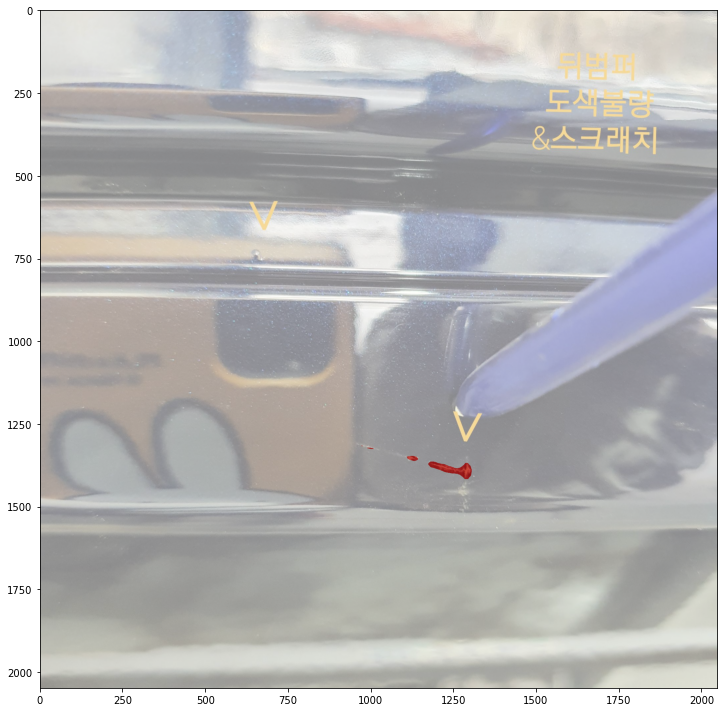

In [ ]:
from mmcv import Config

palette = [[255, 255, 255], [255, 0, 0]]
checkpoint_file = '/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab/epoch_30.pth'  #학습된 모델
checkpoint_cfg = Config.fromfile('/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab/checkpoint_cfg.py')

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(checkpoint_cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/Colab Notebooks/ScratchDataset/img_dir/val/12b3ea27-9cd6-4daf-a69a-0cad7c869bcb.jpg')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


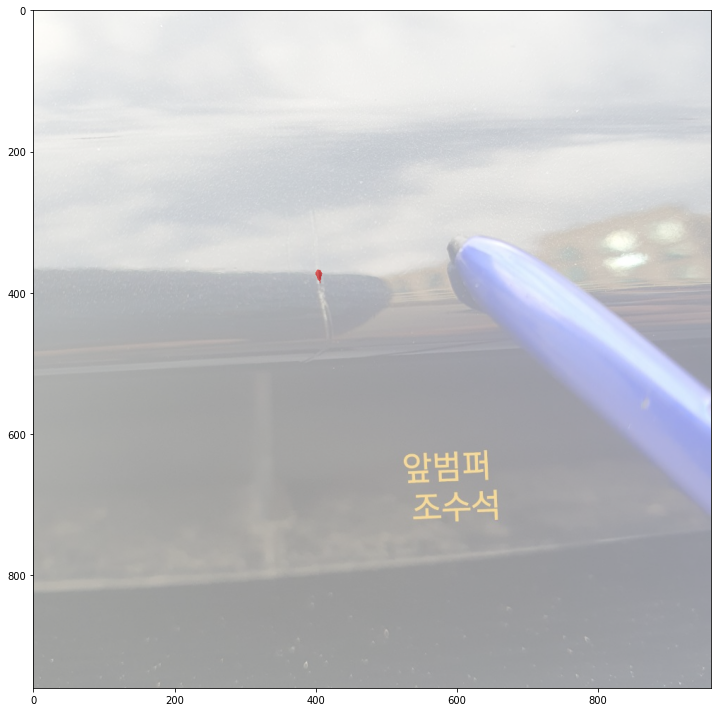

In [ ]:
palette = [[255, 255, 255], [255, 0, 0]]

img = mmcv.imread('/content/drive/MyDrive/Colab Notebooks/ScratchDataset/img_dir/val/1602055211525-5.jpg')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
from mmseg.datasets import build_dataloader, build_dataset

# test용 Dataset과 DataLoader 생성. 
# build_dataset()호출 시 list로 감싸지 않는 것이 train용 dataset 생성시와 차이. 
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        # 반드시 아래 samples_per_gpu 인자값은 1로 설정
        samples_per_gpu=1,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)

# 반드시 아래 코드에서 'img' 키값이 tensor로 출력되어야 함. 
next(iter(data_loader))

2022-07-29 01:57:46,651 - mmseg - INFO - Loaded 108 images


{'img': [tensor([[[[2.2318, 2.2489, 2.2489,  ..., 0.1083, 0.0912, 0.0569],
            [2.2318, 2.2489, 2.2489,  ..., 0.0912, 0.0912, 0.0912],
            [2.2318, 2.2489, 2.2489,  ..., 0.0741, 0.0741, 0.1254],
            ...,
            [1.3070, 1.3070, 1.3070,  ..., 0.7419, 0.7077, 0.7248],
            [1.3070, 1.3070, 1.3070,  ..., 0.7762, 0.7077, 0.7248],
            [1.3070, 1.3070, 1.3070,  ..., 0.8618, 0.7933, 0.8104]],
  
           [[2.3410, 2.3761, 2.3761,  ..., 0.2227, 0.2052, 0.1702],
            [2.3410, 2.3761, 2.3761,  ..., 0.2052, 0.2052, 0.2052],
            [2.3410, 2.3761, 2.3761,  ..., 0.1877, 0.1877, 0.2402],
            ...,
            [1.4832, 1.4832, 1.4832,  ..., 0.8880, 0.8529, 0.8704],
            [1.4832, 1.4832, 1.4832,  ..., 0.9230, 0.8529, 0.8704],
            [1.4832, 1.4832, 1.4832,  ..., 1.0105, 0.9405, 0.9580]],
  
           [[2.3611, 2.3960, 2.3960,  ..., 0.3568, 0.3393, 0.3045],
            [2.3611, 2.3960, 2.3960,  ..., 0.3393, 0.3393, 0.3393],

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

checkpoint_file = '/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab/epoch_30.pth'
checkpoint_cfg = Config.fromfile('/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab/checkpoint_cfg.py')

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(checkpoint_cfg, checkpoint_file, device='cuda:0')

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint2/epoch_12.pth


In [ ]:
from mmseg.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

model_ckpt = MMDataParallel(model_ckpt, device_ids=[0])
# single_gpu_test() 를 호출하여 test데이터 세트의 interence 수행. 반드시 batch size는 1이 되어야 함. 
# 위에서 만든 /content/show_test_output 디렉토리에 interence 결과가 시각화된 이미지가 저장됨. 
outputs = single_gpu_test(model_ckpt, data_loader, True, '/content/drive/MyDrive/Colab Notebooks/ScratchDataset/semantic_checkpoint_deeplab/show_test_output', 0.03)

[                                                  ] 0/108, elapsed: 0s, ETA:

/content/mmsegmentation/mmseg/apis/test.py:69: UserWarning: DeprecationWarning: ``efficient_test`` will be deprecated, the evaluation is CPU memory friendly with pre_eval=True
  'DeprecationWarning: ``efficient_test`` will be deprecated, the '


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 108/108, 1.2 task/s, elapsed: 92s, ETA:     0s